In [1]:
import os
import pandas as pd
import numpy as np
from configs.configuration import Config
from sklearn.metrics.pairwise import cosine_similarity
import cv2

from utils.get_data import get_npy
from utils.top_k_accuracy import accuracy

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from glob import glob
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from model.resnet18 import ResNet18

In [4]:
config = Config(os.path.join(os.getcwd(), "configs/resnet18+fc3_mcpl_adam-ns.yaml"))
Embedding = pd.read_csv(config.embed.path, index_col=0)

---------------------------------- APP CONFIG ----------------------------------
model: 
  name: resnet18
  pretrain: False
zero_shot: False
sampling: 
  size: 30
embed: 
  path: embed/Embedding_0.5_0.001_0.5.csv
loss: 
  name: MCPL
train: 
  source: cha_table/cha.txt
  optim: adam
  lr: 0.005
  max_epoch: 300
  batch_size: 512
  data_shuffle: True
test: 
  source: cha_table/cha_test-Copy1.txt
  batch_size: 512
  data_shuffle: False
aug: 
  aug_func: False
  train_amplify: 1
  test_amplify: 1
--------------------------------------------------------------------------------


In [5]:
def infer(dataloader, Embedding):
    
    label_list = []
    pred_y_list = []
    
    for data in dataloader:
        
        data = data.numpy()

        data = [d/255 for d in data]
        data = torch.tensor(data, dtype=torch.float)
        data = Variable(data.cuda())
        
        # Total Loss
        data = torch.unsqueeze(data, 1)
        pred_y = model(data)
        pred_y_list.extend(pred_y.cpu().detach().numpy())
    return pred_y_list

In [6]:
model = ResNet18(out_dim=341).cuda()

### reload weights
checkpoint = torch.load('save/model_3755cha_allembed_MCPL.h5')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
img = cv2.imread('crop/tsmc-sample-invoices_Invoice_JPEG_Color_HW_TC_INVOICE_ (1).jpg', cv2.IMREAD_GRAYSCALE)

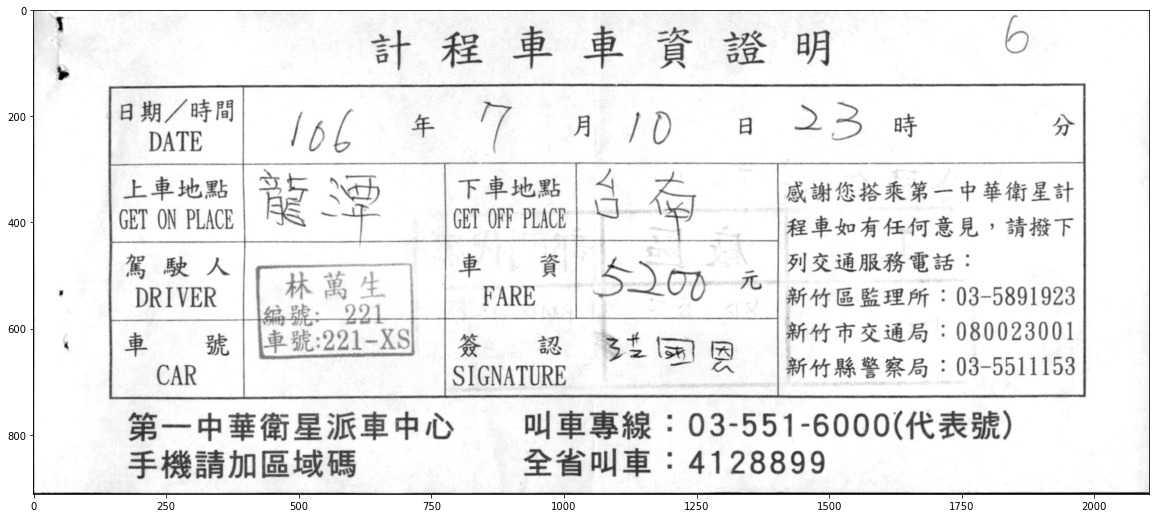

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(img, cmap='gray')
plt.show()

In [9]:
crops_path = glob('crop/*.png')

imgs = []
raw_imgs = []
for path in crops_path:
    crop = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raw_imgs.append(crop)
    resImg = cv2.resize(crop, (64,64), interpolation=cv2.INTER_CUBIC)
    imgs.append(resImg)
    
dataloader = DataLoader(imgs, shuffle=False, batch_size=len(imgs))


pred_y = infer(dataloader, Embedding)

['琖' '玨' '靖' '璋' '墇']


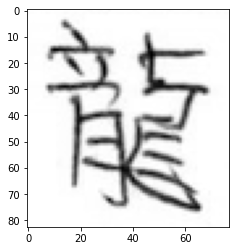

['理' '埤' '晻' '硬' '鉦']


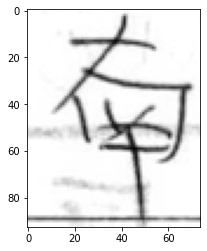

['吩' '哆' '咍' '唠' '啖']


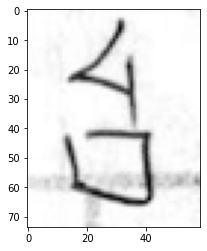

['惢' '劦' '翜' '开' '升']


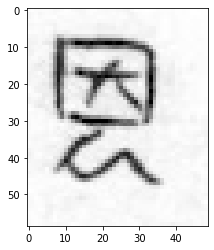

['玨' '垤' '臸' '墇' '璋']


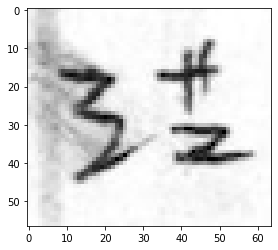

['潭' '汧' '满' '浇' '漠']


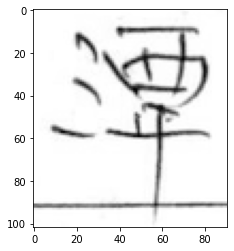

['禿' '四' '秅' '柶' '杶']


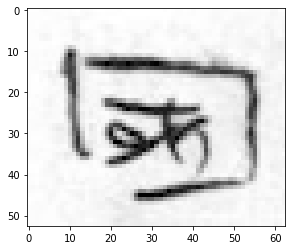

In [11]:
pred_y = np.vstack(pred_y)
score = cosine_similarity(pred_y, Embedding.values.T)
top_score = score.argsort()[:,::-1][:,:5]

for idx, n in enumerate(pred_y):
    print(Embedding.columns[top_score][idx])
    plt.imshow(raw_imgs[idx], cmap='gray')
    plt.show()

In [ ]:
'cha_img_npy/南.npy'